In [696]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

from abc import ABC, abstractmethod
from collections import defaultdict

In [698]:
# Reference: https://jerryfriedman.su.domains/ftp/trebst.pdf

# General Gradient Boosting Machine Algorithm

1. Инициализация
    - Инициализируется первичная модель с константным предсказанием. Константное предсказание должно минимизировать дифференцируемую функцию потерь $L$: 
    $$F_0(x) = argmin_{\hat{y}} \sum_{i=1}^n L(y_i, \hat{y_i})$$
2. Обучение слабых решающих деревьев
    - Для каждого дерева $m = 1,...,M$:
        - Рассчитывается дельта между предсказанным значением $F(x_i)$ и действительным значением $y_i$. Такое значение принято называть псевдо-остатками. Псевдо-остатки можно выразить как отрицательный градиент функции потерь по предсказанному значению:
        $$r_{im} = -[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}]_{F(x) = F_{m-1}(x)}$$
        - Слабое дерево решений обучается на рассчитанных псевдо-остатках $r_{im}$
        - Для каждой листовой ноды $R_{jm}$ рассчитывается значение:
        $$\gamma_{jm} = argmin_{\gamma} \sum_{x_i \in R_{jm}} L(y_i, F_{m-1}(x) + \gamma)$$
        - Итоговая модель обновляется путем добавления предсказания $\gamma_m$ предыдущего дерева:
        $$F_m(x) = F_{m-1}(x) + \eta \gamma_m$$
        Вместо того, чтобы добавить полное предсказание $\gamma_m$, $\gamma_m$ масштабируется на скорость обучения. Таким образом, мы формируем итоговую модель инкрементально, путем добавления небольших шагов в сторону минимизации функции потерь, что помогает избежать переобучения

# Gradient Boosting Machine for Classification

1. Инициализация
    - Определяется log-loss функция потерь:
    $$L(y, p)= -(y*log(p) + (1-y)*log(1-p))$$
    - Инициализируется первичное предсказание, минимизирующее функцию потерь:
    $$log(odds) = \hat{y}_0 = log(\frac{p}{1-p})$$
2. Обучение слабых решающих деревьев
    - Для каждого дерева $m = 1,...,M$:
        - Полученое значение логарифма шансов трансформируется в вероятность с помощью логичестической функции, в данном случае ее частного случая - функции сигмоды:
        $$p = \frac{1}{1+e^{-\hat{y}}}$$
        Производится расчет псевдо-остатков, которые определяются как отрицательная частная производная функции потерь по предсказанию:
        $$r_{im} = -\frac{\partial L_i}{\partial \hat{y_i}} = y_i - p_i$$
        - Новое слабое дерево решений обучается на псевдо-остатках
        - Для каждоый листовой ноды $R_{jm}$ расчитывается значение $\gamma_{jm}$, минимизирующее функцию потерь:
        $$\gamma_{jm} = argmin_{\gamma} \sum_{x_i \in R_{jm}} L(y_i, F_{m-1}(x) + \gamma)$$
        Опуская промежуточные математические детали:
        $$\gamma_{jm} = \frac{\sum_{i \in R_j} y_i - p_i}{\sum_{i \in R_j} p_i(1-p_i)} = \frac{\sum_{i \in R_j} r_{im}}{\sum_{i \in R_j} p_i(1-p_i)}$$
        - Итоговая модель обновляется путем добавления предсказания $\gamma_m$ предыдущего дерева:
        $$F_m(x) = F_{m-1}(x) + \eta \gamma_m$$

> Стоит отметить, что из-за аддитивной природы модели, предсказывать логарифм шансов рациональнее, чем вероятность, поскольку сложение вероятностей может породить недостоверный результат. В следствии этого, модель строится над решающим деревом для регрессии

**Игрушечный пример** <p>
- Набор данных
    
    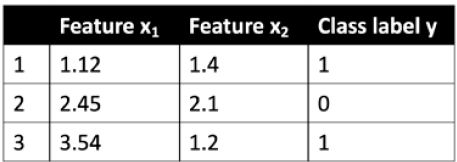
    
- Расчет псевдо остатков
    
    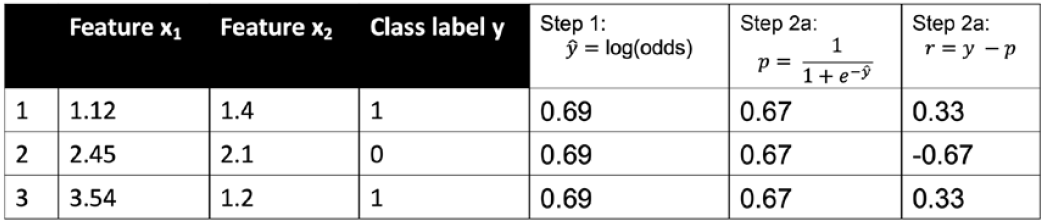
    
- Обучение слабого дерева решений
    
    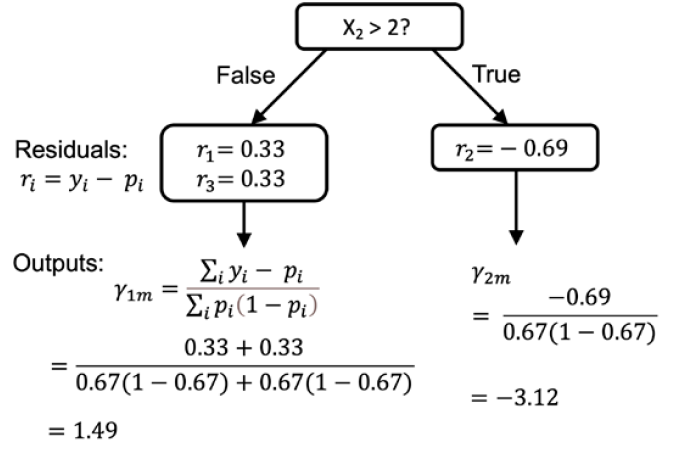
    
- Формирование итоговой модели
    
    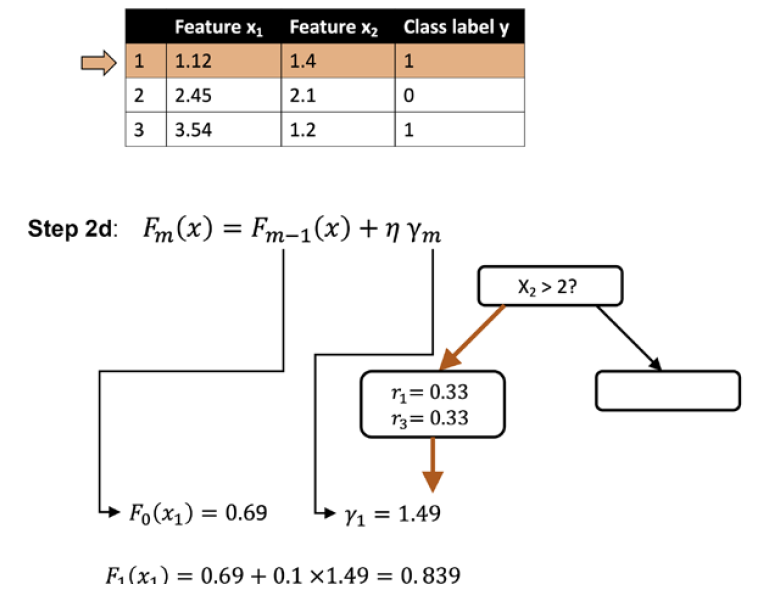
    
- Второй раунд
    
    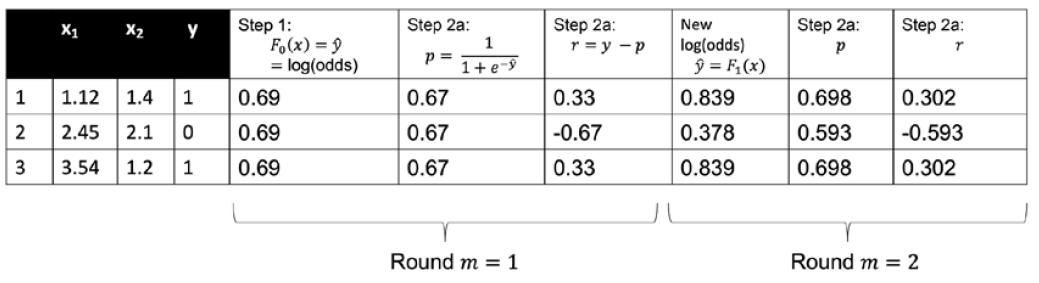

# Gradient Boosting Machine for Regression

1. Инициализация
    - Определяется squared-loss функция потерь:
    $$L(y, \hat{y})= (y - \hat{y})^2$$
    - Инициализируется первичное предсказание, минимизирующее функцию потерь:
    $$\hat{y}_0 = \frac{1}{n} \sum_i^n y_i$$
2. Обучение слабых решающих деревьев
    - Для каждого дерева $m = 1,...,M$:
        - Производится расчет псевдо-остатков, которые определяются как отрицательная частная производная функции потерь по предсказанию:
        $$r_{im} = -\frac{\partial L_i}{\partial \hat{y_i}} = y_i - \hat{y_i}$$
        - Новое слабое дерево решений обучается на псевдо-остатках
        - Для каждоый листовой ноды $R_{jm}$ расчитывается значение $\gamma_{jm}$, минимизирующее функцию потерь:
        $$\gamma_{jm} = argmin_{\gamma} \sum_{x_i \in R_{jm}} L(y_i, F_{m-1}(x) + \gamma)$$
        Опуская промежуточные математические детали:
        $$\gamma_{jm} = \frac{1}{n} \sum_{x_i \in R_{jm}} (y_i - \hat{y_i}) = \frac{1}{n} \sum_{x_i \in R_{jm}} r_{im}$$
        То есть, $\gamma_{jm}$ - стандартное предсказание дерева решений (среднее значение целевой переменной в ноде)
        - Итоговая модель обновляется путем добавления предсказания $\gamma_m$ предыдущего дерева:
        $$F_m(x) = F_{m-1}(x) + \eta \gamma_m$$

# Implementation

In [715]:
class BaseGradientBoosting(ABC):
    '''
    Базовый класс для алгоритма градиентного бустинга. Реализован в простой форме для образовательных целей.
    
    Для классификации функция потерь - log-loss
    Для регрессии функции потерь - squared-loss
    '''
    
    def __init__(
        self, 
        learning_rate: float = 0.1, 
        n_estimators: int = 100, 
        min_samples_split: int = 2,
        max_depth: int = 3
    ) -> None:
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self._decision_trees = []
        
    @abstractmethod
    def _init_decision_tree(self) -> 'instance':
        ''' Инициализирует инстанс дерева решений '''
        pass
    
    @abstractmethod
    def _compute_f0(self, y: np.array) -> float:
        ''' Расчитывает первичное предсказание '''
        pass
    
    @abstractmethod   
    def _update_terminal_regions(self, tree_model: 'instance', X: np.array, y: np.array, residuals: np.array) -> None:
        ''' Обновляет значения листьев дерева решений '''
        pass
       
    @abstractmethod    
    def _transform_ensemble_f(self, ensemble_f: np.array) -> np.array:
        ''' Производит трансформацию финального предсказания модели '''
        pass
    
    def fit(self, X: np.array, y: np.array) -> None:
        self.f0 = self._compute_f0(y)
        ensemble_f = np.ones(X.shape[0]) * self.f0
        for m in range(self.n_estimators):
            residuals = y - self._transform_ensemble_f(ensemble_f)
            decision_tree = self._init_decision_tree()
            decision_tree.fit(X, residuals)
            self._update_terminal_regions(decision_tree, X, y, residuals)
            self._decision_trees.append(decision_tree)
            gamma = decision_tree.predict(X)
            ensemble_f += self.learning_rate * gamma
            
    @abstractmethod
    def predict(self, X: np.array) -> np.array:
        pass

In [717]:
class GradientBoostingRegressor_(BaseGradientBoosting):
    
    def __init__(
        self, 
        learning_rate = 0.1, 
        n_estimators = 100, 
        min_samples_split = 2,
        max_depth = 3,
        criterion = 'squared_error'
    ):
        super().__init__(learning_rate, n_estimators, min_samples_split, max_depth)
        self.criterion = criterion
        
    def _init_decision_tree(self):
        return DecisionTreeRegressor(
                    max_depth = self.max_depth, 
                    min_samples_split = self.min_samples_split, 
                    criterion = self.criterion
        )
    
    def _compute_f0(self, y):
        return np.mean(y)  
       
    def _update_terminal_regions(self, tree_model, X, y, residuals):
        pass # ничего не делаем, поскольку базовое значение листа, расчитываемое деревом решений, является гаммой
           
    def _transform_ensemble_f(self, ensemble_f):
        return ensemble_f # не проивзодим никаких трансформаций
    
    def predict(self, X):
        ensemble_f = np.ones(X.shape[0]) * self.f0
        for m in range(self.n_estimators):
            ensemble_f += self.learning_rate * self._decision_trees[m].predict(X)
        return ensemble_f

In [719]:
class GradientBoostingClassifier_(BaseGradientBoosting):
    
    def __init__(
        self, 
        learning_rate = 0.1, 
        n_estimators = 100, 
        min_samples_split = 2,
        max_depth = 3,
        criterion = 'squared_error'
    ):
        super().__init__(learning_rate, n_estimators, min_samples_split, max_depth)
        self.criterion = criterion
        
    def _init_decision_tree(self):
        return DecisionTreeRegressor(
                    max_depth = self.max_depth, 
                    min_samples_split = self.min_samples_split, 
                    criterion = self.criterion
        )
    
    def _compute_f0(self, y):
        p = np.mean(y)
        return np.log(p / (1 - p))
       
    def _update_terminal_regions(self, tree_model, X, y, residuals):
        leafs = tree_model.apply(X)
        unique_leafs = np.unique(leafs)
        for leaf in unique_leafs:
            idx = np.nonzero(leafs == leaf)[0]
            p = y[idx] - residuals[idx]
            numerator = np.sum(residuals[idx])
            denominator = np.sum(p / (1 - p))
            gamma = numerator / denominator
            tree_model.tree_.value[leaf, 0, 0] = gamma
           
    def _transform_ensemble_f(self, ensemble_f):
        return 1 / (1 + np.exp(-ensemble_f))
    
    def predict_proba(self, X: np.array) -> np.array:
        ensemble_f = np.ones(X.shape[0]) * self.f0
        for m in range(self.n_estimators):
            ensemble_f += self.learning_rate * self._decision_trees[m].predict(X)
        return self._transform_ensemble_f(ensemble_f)
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs > 0.5).astype(int)

In [721]:
X, y = make_regression(n_samples=5000, n_features=10, n_informative=6, noise=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [723]:
custom_model = GradientBoostingRegressor_(n_estimators=100, max_depth=3, min_samples_split=2, learning_rate=0.1)
sklearn_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, min_samples_split=2, learning_rate=0.1, criterion='squared_error')
custom_model.fit(X_train, y_train)
sklearn_model.fit(X_train, y_train)
custom_pred = custom_model.predict(X_test)
sklearn_pred = sklearn_model.predict(X_test)

print('\n---Results---\n')
print(f'custom MSE: {mean_squared_error(y_test, custom_pred).round(2)}')
print(f'sklearn MSE: {mean_squared_error(y_test, sklearn_pred).round(2)}')


---Results---

custom MSE: 572.39
sklearn MSE: 572.66


In [724]:
X, y = make_classification(n_samples=5000, n_features=10, n_informative=6, n_redundant=0, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [725]:
custom_model = GradientBoostingClassifier_(n_estimators=100, max_depth=3, min_samples_split=2, learning_rate=0.1)
sklearn_model = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_split=2, learning_rate=0.1, criterion='squared_error')
custom_model.fit(X_train, y_train)
sklearn_model.fit(X_train, y_train)
custom_pred = custom_model.predict(X_test)
sklearn_pred = sklearn_model.predict(X_test)
custom_prob = custom_model.predict_proba(X_test)
sklearn_prob = sklearn_model.predict_proba(X_test)[:,1]

print('\n---Results---\n')
print(f'custom accuracy: {accuracy_score(y_test, custom_pred).round(2)}')
print(f'sklearn accuracy: {accuracy_score(y_test, sklearn_pred).round(2)}')
print(f'custom roc-auc: {roc_auc_score(y_test, custom_prob).round(2)}')
print(f'sklearn roc-auc: {roc_auc_score(y_test, sklearn_prob).round(2)}')


---Results---

custom accuracy: 0.84
sklearn accuracy: 0.89
custom roc-auc: 0.92
sklearn roc-auc: 0.97
